# Results

In [83]:
import os
from pathlib import Path
import time
from datetime import datetime
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import model_from_json

In [84]:
sns.set(style = 'whitegrid')
colors = sns.color_palette()
colorsp1 = colors
colorsp1.pop(0)
colorsp1.append(colors[0])

def format_plot(ax, plt):
    ax.set_ylabel('validation accuracy')
    plt.ylim(bottom=0.35, top=1.05)
    ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    ax.set_xlabel('Dataset')
    plt.tight_layout()
    
def print_stats(data, name):
    print(name,  ':')
    print('Quantiles:\n', data['val_acc'].quantile([0.25, 0.5, 0.75]) )
    print('Mean:', data['val_acc'].mean())
    
def print_means(data, names):
    print('Mean averages:')
    for d, n, in zip(data, names):
        print(d['val_acc'].mean(), n)
        

def plot_confusion_matrix(cm, title='Normalised confusion matrix', name=''):
    ''' Plot the normalised confusion matrix
    Parameters
    cm : array - normalised confusion matrix
    Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
    'Confusion Matrix' https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    '''
    classes = ['Positive', 'Negative']
    cmap=plt.cm.Blues
    sns.set_style('dark')
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(format=FuncFormatter('{0:.0%}'.format))
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.clim(0, 1)
    fmt = '.0%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.tight_layout()
    file_name = 'cm_devnet_'+name+'.png'
    plt.savefig(file_name, bbox_inches='tight')
    sns.set(style = 'whitegrid')

In [85]:
def readucr(filename):
    data = np.loadtxt(Path(filename))
    Y = data[:,0]
    X = data[:,1:]
    return X, Y


def dataset_size(filename):
    if 'private_dog0' == filename or 'private_dog1' == filename or 'private_dog2' == filename:
        fdir = '../../data/private_data/private_events_dev' 
    elif 'private' in filename:
        fdir = '../../data/private_data/private_events_dev2' 
        
    _, y_train = readucr(fdir+'/'+filename+'/'+filename+'_TRAIN.txt')
    _, y_test = readucr(fdir+'/'+filename+'/'+filename+'_TEST.txt')
    return y_train.shape[0]+y_test.shape[0]


def end_test_dataset_size(filename):
    fdir = '../../data/private_data/private_events_dev2' 
    _, y_endtest = readucr(fdir+'/'+filename+'/'+filename+'_END_TEST.txt')
    return y_endtest.shape[0]


def sample_sizes(num_dataset, k, m):
    ''' Given a dataset size, calculate the number of samples used in the calculations of m iterations
    of k-fold cross validation.
    Returns 
    ND 
        number of data samples used to calculate the validation accuracy 
    NT
        number of tests used run
    num_text 
        a string that can be used in plots to write ND and NT with subscripts
    '''
    N = num_dataset
    ND = str(round(N/k))
    NT = str(k*m)
    num_text = '($N_D$='+ND+', $N_T$='+NT+')'
    return ND, NT, num_text

# Example confusion matrix and box plot

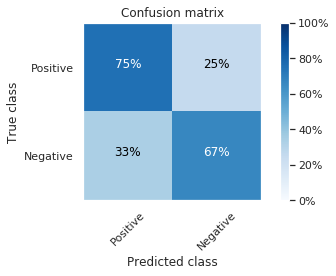

In [86]:
y_true = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
y_pred = [1, 1, 0, 1, 0, 0, 0, 1, 1, 0]
cm = confusion_matrix(y_true, y_pred, labels=[1,0])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
title = 'Confusion matrix' # ($N_D$=10)'
plot_confusion_matrix(cm_norm, title=title, name='example')

          0
0  0.933333
1  0.933333
2  0.866667
3  0.866667
4  0.800000
5  0.800000
6  0.666667
7  0.666667
8  0.666667
9  0.600000
mean 0.78 std 0.12191881532751293
quantiles 0.25    0.666667
0.50    0.800000
0.75    0.866667
Name: 0, dtype: float64


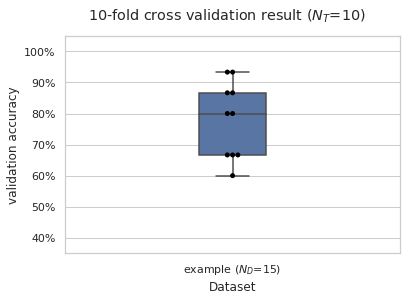

In [87]:
all_data = pd.DataFrame([14, 14, 13, 13, 12, 12, 10, 10, 10, 9])
all_data = all_data/15
print(all_data)
print('mean', all_data[0].mean(), 'std', all_data[0].std())
print('quantiles', all_data[0].quantile([0.25, 0.5, 0.75]))
ax = sns.boxplot(data=all_data, width=0.2)
ax = sns.swarmplot(data=all_data, color='black')
title = '10-fold cross validation result ($N_T$=10)'
plt.suptitle(title)
ax.set_ylabel('validation accuracy')
plt.ylim(bottom=0.35, top=1.05)
ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
ax.set_xlabel('Dataset')
plt.xticks([0], ['example ($N_D$=15)'])
plt.savefig('boxplot_example.png', bbox_inches='tight')

# Confirm performance of untuned DNNs : GunPoint

In [88]:
print('Single train and test. Same train:test split as UCR TSC archive. Reporting validation accuracy and error.', '\n')

print('1-NN (1-nearest neighbor)')
print('0.9133333333333333')
print(1-0.9133333333333333, 'error\n')

file = '../../logs/2019-05-10T20:18/GunPoint/mlpwang_summary.csv'
data1 = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
print(file, '(MLP Wang)')
print('No. results:', data1.shape[0])
print(data1.iloc[0]['val_acc'].mean())
print(1-data1['val_acc'].mean(), 'error\n')

file = '../../logs/2019-03-31T18:07/GunPoint/devnet_summary.csv'
data2 = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
print(file, '(FCN Wang)')
print('No. results:', data2.shape[0])
print(data2['val_acc'].mean())
print(1-data2['val_acc'].mean(), 'error\n')

file = '../../logs/2019-03-29T15:29/GunPoint/devnet_summary.csv'
#file = '../../logs/2019-05-11T13:42/GunPoint/resnet_summary.csv'
data2 = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
print(file, '(ResNet Wang)')
print('No. results:', data2.shape[0])
print(data2['val_acc'].mean())
print(1-data2['val_acc'].mean(), 'error\n')


Single train and test. Same train:test split as UCR TSC archive. Reporting validation accuracy and error. 

1-NN (1-nearest neighbor)
0.9133333333333333
0.08666666666666667 error

../../logs/2019-05-10T20:18/GunPoint/mlpwang_summary.csv (MLP Wang)
No. results: 1
0.9333333373069764
0.06666666269302357 error

../../logs/2019-03-31T18:07/GunPoint/devnet_summary.csv (FCN Wang)
No. results: 1
1.0
0.0 error

../../logs/2019-03-29T15:29/GunPoint/devnet_summary.csv (ResNet Wang)
No. results: 1
0.993333339691162
0.006666660308838002 error



In [89]:
# 10-fold cross validation
ND, NT, num_text = sample_sizes(200, k=10, m=1)
print(num_text, '\n')

print('1-NN (1-nearest neighbor)')
print(0.9450000000000001)
print(0.043779751788545644, '\n')

file = '../../logs/2019-03-17T16:35/GunPoint/mlpwang_summary.csv'
data1 = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
name1 = 'GunPoint'
print(file, '(MLP Wang)')
print(data1['val_acc'].mean())
print(data1['val_acc'].std())
print('Number of folds', data1['val_acc'].count(), '\n')

file = '../../logs/2019-05-09T09:25/GunPoint/devnet_summary.csv'
data2 = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
print(file, '(FCN Wang)')
print(data2['val_acc'].mean())
print(data2['val_acc'].std())
print('Number of folds', data2['val_acc'].count(), '\n')

file = '../../logs/2019-03-18T17:32/GunPoint/resnet_summary.csv'
data2 = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
print(file, '(ResNet Wang)')
print(data2['val_acc'].mean())
print(data2['val_acc'].std())
print('Number of folds', data2['val_acc'].count(), '\n')

($N_D$=20, $N_T$=10) 

1-NN (1-nearest neighbor)
0.9450000000000001
0.043779751788545644 

../../logs/2019-03-17T16:35/GunPoint/mlpwang_summary.csv (MLP Wang)
0.9649999976158142
0.05296749352309429
Number of folds 10 

../../logs/2019-05-09T09:25/GunPoint/devnet_summary.csv (FCN Wang)
1.0
0.0
Number of folds 10 

../../logs/2019-03-18T17:32/GunPoint/resnet_summary.csv (ResNet Wang)
0.9949999988079071
0.015811392070570664
Number of folds 10 



# Untuned models : all dogs data (balanced dataset)

[['1-NN', 0.6024193548387097, 0.0433121162604792], ['MLP', 0.6248848021030426, 0.06573279448330743], ['FCN', 0.6070060521364212, 0.06595959534671478], ['ResNet', 0.6538658618927002, 0.06358524472315732]]


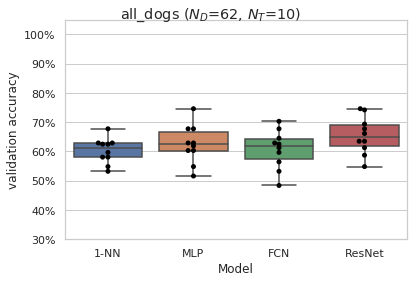

In [90]:
all_data = list()
all_names = list()
results = []
N = dataset_size('private_balanced')
ND, NT, num_text = sample_sizes(N, k=10, m=1)

file = '../../logs/2019-05-10T16:36/private_balanced/nearestneighbours_summary.csv'
data = pd.read_csv(file, header=None, names=['val_acc'])
all_data.append(data['val_acc'])
all_names.append('1-NN')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-03-21T14:23/private_balanced/mlpwang_summary.csv'
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
all_names.append('MLP')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-05-09T12:30/private_balanced/devnet_summary.csv'
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
all_names.append('FCN')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-03-20T19:47/private_balanced/resnet_summary.csv'
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
all_names.append('ResNet')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

print(results)

ax = sns.boxplot(data=all_data)
ax = sns.swarmplot(data=all_data, color='black')
title = 'all_dogs '+num_text
plt.suptitle(title)
plt.xticks([0, 1, 2, 3], [all_names[0], all_names[1], all_names[2], all_names[3]])
format_plot(ax, plt)
ax.set_xlabel('Model')
plt.ylim(bottom=0.30, top=1.05)
plt.savefig('boxplot_alldogs.png', bbox_inches='tight')


# Train on dog0 data only

[['1-NN', 0.6, 0.1476844595361251], ['MLP', 0.6333333373069763, 0.09514986992191721], ['FCN', 0.6333333373069763, 0.10861391091418572], ['ResNet', 0.6277777880430222, 0.09460770067177357]]


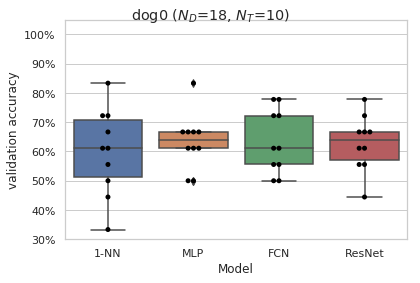

In [91]:
all_data = list()
all_names = list()
results = []
N = dataset_size('private_dog0')
ND, NT, num_text = sample_sizes(N, k=10, m=1)

file = '../../logs/2019-05-10T10:19/private_dog0/nearestneighbours_summary.csv'
data = pd.read_csv(file, header=None, names=['val_acc'])
all_data.append(data['val_acc'])
all_names.append('1-NN')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-03-17T14:56/private_dog0/mlpwang_summary.csv'
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
all_names.append('MLP')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-05-10T10:17/private_dog0/devnet_summary.csv'
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
all_names.append('FCN')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-03-18T19:12/private_dog0/resnet_summary.csv'
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
all_names.append('ResNet')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

print(results)

ax = sns.boxplot(data=all_data)
ax = sns.swarmplot(data=all_data, color='black')
title = 'dog0 '+num_text
plt.suptitle(title)
plt.xticks([0, 1, 2, 3], all_names)
format_plot(ax, plt)
ax.set_xlabel('Model')
plt.ylim(bottom=0.30, top=1.05)
plt.savefig('boxplot_allModels_dog0.png', bbox_inches='tight')

# Dog accuracy

dog_result   FN  FP   TN   TP  All
dog                               
Furby        42  13   95   68  218
Ozzy         35  12   92   53  192
Sye          45  13   87   69  214
All         122  38  274  190  624
dog_result  Accuracy       TPR       TNR       FPR       FNR
dog                                                         
Furby       0.747706  0.618182  0.879630  0.120370  0.381818
Ozzy        0.755208  0.602273  0.884615  0.115385  0.397727
Sye         0.728972  0.605263  0.870000  0.130000  0.394737
All         0.743590  0.608974  0.878205  0.121795  0.391026


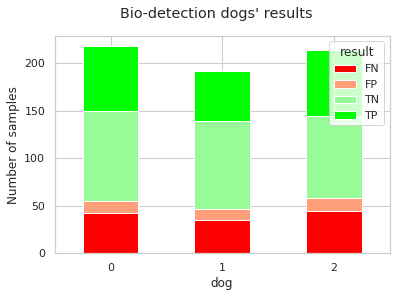

In [92]:
datadir = '../../data/private_data/private_events_dev2' 
fname = 'private_balanced'
meta_train = pd.read_csv(datadir+'/'+fname+'/'+fname+'_TRAIN_meta.txt', sep=',', parse_dates=['date'])
meta_test = pd.read_csv(datadir+'/'+fname+'/'+fname+'_TEST_meta.txt', sep=',', parse_dates=['date'])
meta = pd.concat([meta_train, meta_test])

colors = ['red', 'lightsalmon', 'palegreen', 'lime' ]   
meta.groupby('dog')['dog_result'] \
    .value_counts() \
    .sort_index(ascending=False) \
    .unstack(level=1) \
    .plot.bar(stacked=True, color=colors)

plt.xticks([0, 1, 2], ['0', '1', '2'])
plt.xticks(rotation=0)
plt.ylabel('Number of samples')
plt.suptitle('Bio-detection dogs\' results')
plt.legend(title='result')
plt.savefig('bar_dogAccuracy.png', bbox_inches='tight')

results = meta.pivot_table('run', index='dog', columns='dog_result', aggfunc=len, fill_value=0, margins=True)
print(results)


# Calculate Accuracy and FNR, false negative rate, etc.
P = results.TP+results.FN
N = results.TN+results.FP
results['Accuracy'] = (results.TP+results.TN)/(P+N)
results['TPR'] = results.TP/P
results['FPR'] = results.FP/N
results['TNR'] = results.TN/N
results['FNR'] = results.FN/P
print(results[['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR']])

# MLP : all dogs - dog0 - dog0 correct

[['all_dogs ($N_D$=62)', 0.6248848021030426, 0.06573279448330743], ['dog0 ($N_D$=18)', 0.6333333373069763, 0.09514986992191721], ['dog0_correct ($N_D$=14)', 0.8307692289352417, 0.07087698871481754]]


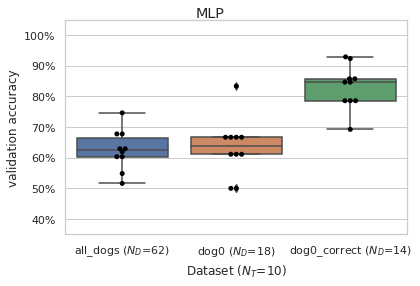

In [93]:
all_data = list()
all_names = list()
results = []
ND, NT, __ = sample_sizes(dataset_size('private_balanced'), k=10, m=1)

file = '../../logs/2019-03-21T14:23/private_balanced/mlpwang_summary.csv'
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
name = 'all_dogs ($N_D$='+str(ND)+')'
all_names.append(name)
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-03-17T14:56/private_dog0/mlpwang_summary.csv'
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
ND, __, __ = sample_sizes(dataset_size('private_dog0'), k=10, m=1)
name = 'dog0 ($N_D$='+str(ND)+')'
all_names.append(name)
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-03-17T18:16/private_dog0_correct/mlpwang_summary.csv'
#file = '../../logs/2019-05-11T08:53/private_dog0_correct_plus/mlpwang_summary.csv'
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
ND, __, __ = sample_sizes(dataset_size('private_dog0_correct'), k=10, m=1)
name = 'dog0_correct ($N_D$='+str(ND)+')'
all_names.append(name)
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

print(results)

ax = sns.boxplot(data=all_data)
ax = sns.swarmplot(data=all_data, color='black')
plt.suptitle('MLP')
plt.xticks([0, 1, 2], [all_names[0], all_names[1], all_names[2]])
format_plot(ax, plt)
ax.set_xlabel('Dataset ($N_T$='+NT+')')
plt.savefig('boxplot_MLPWang.png', bbox_inches='tight')

# MLP : dog1 and dog2 all vs correct

[['dog0\n($N_D$=18)', 0.6333333373069763, 0.09514986992191721], ['dog0_correct\n($N_D$=14)', 0.8307692289352417, 0.07087698871481754], ['dog1\n($N_D$=15)', 0.6455357164144516, 0.16426036845461672], ['dog1_correct\n($N_D$=11)', 0.9099999904632569, 0.09944289499871888], ['dog2\n($N_D$=16)', 0.51875, 0.13517606831256945], ['dog2_correct\n($N_D$=14)', 0.7464285731315613, 0.0898000996055614]]


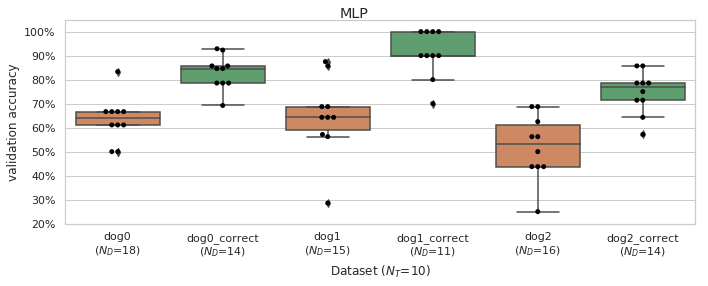

In [94]:
all_data = list()
all_names = list()
results = []
fig=plt.figure(figsize=(10, 4))
ND, NT, __ = sample_sizes(dataset_size('private_balanced'), k=10, m=1)

file = '../../logs/2019-03-17T14:56/private_dog0/mlpwang_summary.csv'
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
ND, __, __ = sample_sizes(dataset_size('private_dog0'), k=10, m=1)
name = 'dog0\n($N_D$='+str(ND)+')'
all_names.append(name)
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-03-17T18:16/private_dog0_correct/mlpwang_summary.csv'
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
ND, __, __ = sample_sizes(dataset_size('private_dog0_correct'), k=10, m=1)
name = 'dog0_correct\n($N_D$='+str(ND)+')'
all_names.append(name)
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-03-23T08:51/private_dog1/mlpwang_summary.csv'
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
ND, __, __ = sample_sizes(dataset_size('private_dog1'), k=10, m=1)
name = 'dog1\n($N_D$='+str(ND)+')'
all_names.append(name)
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-03-24T09:56/private_dog1_correct/mlpwang_summary.csv'
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
ND, __, __ = sample_sizes(dataset_size('private_dog1_correct'), k=10, m=1)
name = 'dog1_correct\n($N_D$='+str(ND)+')'
all_names.append(name)
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-03-23T22:02/private_dog2/mlpwang_summary.csv'
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
ND, __, __ = sample_sizes(dataset_size('private_dog2'), k=10, m=1)
name = 'dog2\n($N_D$='+str(ND)+')'
all_names.append(name)
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-03-23T19:47/private_dog2_correct/mlpwang_summary.csv'
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
ND, __, __ = sample_sizes(dataset_size('private_dog2_correct'), k=10, m=1)
name = 'dog2_correct\n($N_D$='+str(ND)+')'
all_names.append(name)
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

print(results)

clrs = [colorsp1[0], colorsp1[1], colorsp1[0], colorsp1[1], colorsp1[0], colorsp1[1]]
ax = sns.boxplot(data=all_data, palette=clrs)
ax = sns.swarmplot(data=all_data, color='black')
plt.suptitle('MLP')
plt.xticks([0, 1, 2, 3, 4, 5], all_names)
format_plot(ax, plt)
ax.set_xlabel('Dataset ($N_T$='+NT+')')
plt.ylim(bottom=0.20, top=1.05)
plt.savefig('boxplot_MLPWang_dog012Correct.png', bbox_inches='tight')

# All models : dog0 correct

   run      loss   val_acc  epoch  time
0    0  0.000071  0.666667   1464    12
1    1  0.001466  0.300000   1448    13
2    2  0.000314  0.800000   1487    13
3    3  0.000677  0.500000   1432    13
4    4  0.002410  0.600000   1347    13
boxplot_allModels_dog0Correct
[['1-NN', 0.7683333333333333, 0.16563570021340565], ['MLP', 0.7966666638851165, 0.10937532669099445], ['FCN', 0.7, 0.16329931050773056], ['ResNet', 0.5666666805744172, 0.13052600544211596]]


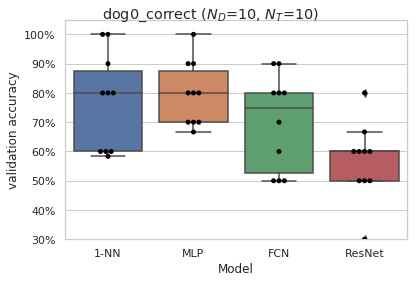

In [95]:
all_data = list()
all_names = list()
results = []
ND, NT, num_text = sample_sizes(dataset_size('private_dog0_correct_plus'), k=10, m=1)

file = '../../logs/2019-05-09T14:07/private_dog0_correct_plus/nearestneighbours_summary.csv'
data = pd.read_csv(file, header=None, names=['val_acc'])
all_data.append(data['val_acc'])
all_names.append('1-NN')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-05-11T08:53/private_dog0_correct_plus/mlpwang_summary.csv' # 1h 16mins
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
all_names.append('MLP')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-05-09T15:15/private_dog0_correct_plus/devnet_summary.csv' # 26mins
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
all_names.append('FCN')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-05-11T09:51/private_dog0_correct_plus/resnet_summary.csv' # 2h
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
print(data.head())
all_data.append(data['val_acc'])
all_names.append('ResNet')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

print('boxplot_allModels_dog0Correct')
print(results)

ax = sns.boxplot(data=all_data)
ax = sns.swarmplot(data=all_data, color='black')
title = 'dog0_correct '+num_text
plt.suptitle(title)
plt.xticks([0, 1, 2, 3], [all_names[0], all_names[1], all_names[2], all_names[3]])
format_plot(ax, plt)
ax.set_xlabel('Model')
plt.ylim(bottom=0.30, top=1.05)
plt.savefig('boxplot_allModels_dog0Correct.png', bbox_inches='tight')

# MLP hyperparameter tuning

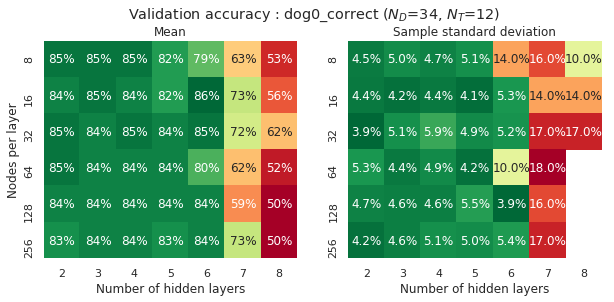

In [96]:
ND, NT, num_text = sample_sizes(dataset_size('private_dog0_correct_plus'), k=3, m=4)

acc = [[ 0.85,0.85, 0.85, 0.82, 0.79, 0.63, 0.53],
        [0.84,0.85, 0.84, 0.82, 0.86, 0.73, 0.56],
        [0.85,0.84, 0.85, 0.84, 0.85, 0.72, 0.62],
        [0.85,0.84, 0.84, 0.84, 0.8, 0.62, 0.52],
        [0.84,0.84, 0.84, 0.84, 0.84, 0.59, 0.5],
        [0.83,0.84, 0.84, 0.83, 0.84, 0.73, 0.5]]

std = [[ 0.045,0.05, 0.047, 0.051, 0.14, 0.16, 0.1],
        [0.044,0.042, 0.044, 0.041, 0.053, 0.14, 0.14],
        [0.039,0.051, 0.059, 0.049, 0.052, 0.17, 0.17],
        [0.053,0.044, 0.049, 0.042, 0.1, 0.18,  np.nan],
        [0.047,0.046, 0.046, 0.055, 0.039, 0.16,  np.nan],
        [0.042,0.046, 0.051, 0.05, 0.054, 0.17,  np.nan]]

fig = plt.figure(figsize=(10, 4))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122, sharey=ax0)
sns.heatmap(acc, cmap='RdYlGn', annot=True, fmt = '.0%', cbar=False, ax=ax0)
sns.heatmap(std, cmap='RdYlGn_r', annot=True, fmt = '.1%', cbar=False, ax=ax1)
ax0.set_xlabel('Number of hidden layers')
ax1.set_xlabel('Number of hidden layers')
ax0.set_ylabel('Nodes per layer')
ax0.set_xticklabels([2, 3, 4, 5, 6, 7, 8])
ax1.set_xticklabels([2, 3, 4, 5, 6, 7, 8])
ax0.set_yticklabels([8, 16, 32, 64, 128, 256])
ax0.set_title('Mean')
ax1.set_title('Sample standard deviation')
title = 'Validation accuracy : dog0_correct '+num_text
plt.suptitle(title, y=1)     
plt.savefig('heatmap_MLP_dog0Correct.png', bbox_inches='tight')

# Selected models

[['MLP\nWang et al.', 0.7966666638851165, 0.10937532669099445], ['MLP\ntuned', 0.8533333241939545, 0.10680546467191256], ['FCN\ntuned', 0.8516666650772095, 0.08622751624761629], ['ResNet\ntuned', 0.8366666674613953, 0.10147065437939802]]


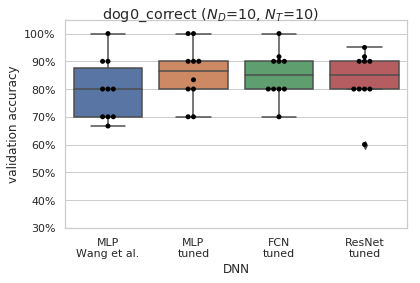

In [97]:
all_data = list()
all_names = list()
results = []
ND, NT, num_text = sample_sizes(dataset_size('private_dog0_correct_plus'), k=10, m=1)

file = '../../logs/2019-05-11T08:53/private_dog0_correct_plus/mlpwang_summary.csv' # 1h 16mins
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
all_names.append('MLP\nWang et al.') #'1000/500/500/500/2')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-05-12T14:20/private_dog0_correct_plus/devnet_summary.csv' # 3 mins
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time', 'end_test'])
all_data.append(data['val_acc'])
all_names.append('MLP\ntuned') #\n(1000/16/16/16/1)')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-04-28T10:42/private_dog0_correct_plus/devnet_summary.csv' # 6 mins
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
all_names.append('FCN\ntuned')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

file = '../../logs/2019-04-19T18:00/private_dog0_correct_plus/devnet_summary.csv' # 52 mins
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
all_data.append(data['val_acc'])
all_names.append('ResNet\ntuned')
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])

print(results)

ax = sns.boxplot(data=all_data)
ax = sns.swarmplot(data=all_data, color='black')
plt.suptitle('dog0_correct '+num_text)
plt.xticks([0, 1, 2, 3], all_names)
format_plot(ax, plt)
ax.set_xlabel('DNN')
plt.ylim(bottom=0.30, top=1.05)
plt.savefig('boxplot_allTunedModels_dog0Correct.png', bbox_inches='tight')

# Dataset sizes

In [98]:
def print_sizes(filename):
    if 'private_dog0' == filename or 'private_dog1' == filename or 'private_dog2' == filename:
        fdir = '../../data/private_data/private_events_dev' 
    elif 'private' in filename:
        fdir = '../../data/private_data/private_events_dev2' 
        
    _, y_train = readucr(fdir+'/'+filename+'/'+filename+'_TRAIN.txt')
    _, y_test = readucr(fdir+'/'+filename+'/'+filename+'_TEST.txt')
    if 'correct_plus' in filename:
        _, y_other = readucr(fdir+'/'+filename+'/'+filename+'_END_TEST.txt')
        meta = pd.read_csv(fdir+'/'+filename+'/'+filename+'_END_TEST'+'_meta.txt', sep=',', parse_dates=['date'])
    else:
        y_other = None
        
    print(filename)
    print('Train:', y_train.shape[0])
    print('Test:', y_test.shape[0])
    print('Train+Test:', y_train.shape[0]+y_test.shape[0])
    if y_other is not None:
        print('End test:', y_other.shape[0])
        print('class 0:', (y_other == 0).sum(), 'class 1:', (y_other == 1).sum())
        print_dog_accuracy(fdir, filename)
    print('\n')
    

def print_dog_accuracy(fdir, filename):
    meta = pd.read_csv(fdir+'/'+filename+'/'+filename+'_END_TEST'+'_meta.txt', sep=',', parse_dates=['date'])
    dog_correct = meta[meta['class']==meta['dog_pred']]
    dog_incorrect = meta[meta['class']!=meta['dog_pred']]
    print('dog correct:', dog_correct.shape[0], 'dog incorrect:', dog_incorrect.shape[0])
    print('dog accuracy:', dog_correct.shape[0]/(dog_correct.shape[0]+dog_incorrect.shape[0]))

In [99]:
flist = ['private_balanced', 'private_correct_plus',
         'private_dog0', 'private_dog0_correct', 'private_dog0_correct_plus',
        'private_dog1', 'private_dog1_correct_plus',
        'private_dog2', 'private_dog2_correct_plus']
for fname in flist:
    print_sizes(fname)

private_balanced
Train: 468
Test: 156
Train+Test: 624


private_correct_plus
Train: 213
Test: 71
Train+Test: 284
End test: 154
class 0: 77 class 1: 77
dog correct: 117 dog incorrect: 37
dog accuracy: 0.7597402597402597


private_dog0
Train: 135
Test: 45
Train+Test: 180


private_dog0_correct
Train: 102
Test: 34
Train+Test: 136


private_dog0_correct_plus
Train: 76
Test: 26
Train+Test: 102
End test: 50
class 0: 25 class 1: 25
dog correct: 38 dog incorrect: 12
dog accuracy: 0.76


private_dog1
Train: 111
Test: 37
Train+Test: 148


private_dog1_correct_plus
Train: 57
Test: 19
Train+Test: 76
End test: 54
class 0: 27 class 1: 27
dog correct: 39 dog incorrect: 15
dog accuracy: 0.7222222222222222


private_dog2
Train: 120
Test: 40
Train+Test: 160


private_dog2_correct_plus
Train: 79
Test: 27
Train+Test: 106
End test: 48
class 0: 24 class 1: 24
dog correct: 38 dog incorrect: 10
dog accuracy: 0.7916666666666666




In [100]:
# result set sizes
file = '../../logs/2019-05-06T17:01/private_dog0_correct_plus/devnet_summary.csv' # 4 x 3-fold
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
print(file)
print(data.shape[0], '\n')

file = '../../logs/2019-05-12T14:20/private_dog0_correct_plus/devnet_summary.csv' # 1 x 10-fold
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time'])
print(file)
print(data.shape[0], '\n')

../../logs/2019-05-06T17:01/private_dog0_correct_plus/devnet_summary.csv
12 

../../logs/2019-05-12T14:20/private_dog0_correct_plus/devnet_summary.csv
10 



# k-fold cross validation including end test
Train on balanced data where dog was correct. Test on balanced, realistic dataset (samples not used during training or validation).

4 iterations of 3-fold cross validation.

../../logs/2019-05-11T18:17/private_dog0_correct_plus/devnet_summary.csv
($N_D$=34, $N_T$=12) k-fold CV:
N= 102 val_acc 0.8504901826381683 std 0.05240118930574692 

dog correct: 38 dog incorrect: 12
dog accuracy: 0.76


../../logs/2019-05-11T19:09/private_correct_plus/devnet_summary.csv
($N_D$=95, $N_T$=12) k-fold CV:
N= 284 val_acc 0.8302305142084757 std 0.024279033311195537 

dog correct: 117 dog incorrect: 37
dog accuracy: 0.7597402597402597


[['dog0\n($N_D$=50)', 0.6416666666666666, 0.03563280749108847], ['all_dogs\n($N_D$=154)', 0.6991342058333333, 0.01217450244528254]]


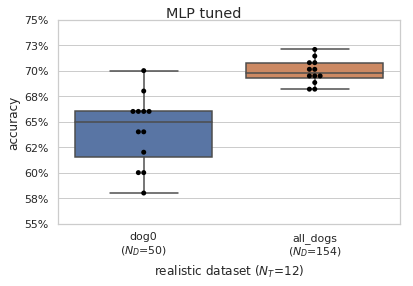

In [101]:
all_data = list()
all_names = list()
results = []
__, NT, __ = sample_sizes(dataset_size('private_dog0_correct_plus'), k=3, m=4)

file = '../../logs/2019-05-11T18:17/private_dog0_correct_plus/devnet_summary.csv' # 7 mins
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time', 'end_test_acc'])
all_data.append(data['end_test_acc'])
name = 'dog0\n($N_D$='+str(end_test_dataset_size('private_dog0_correct_plus'))+')'
all_names.append(name) 
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])
print(file)
ND, NT, num_text = sample_sizes(dataset_size('private_dog0_correct_plus'), k=3, m=4)
print(num_text, 'k-fold CV:')
print('N=', dataset_size('private_dog0_correct_plus'), 'val_acc', data['val_acc'].mean(), 'std', data['val_acc'].std(),'\n')
print_dog_accuracy(datadir, 'private_dog0_correct_plus')
print('\n')

file = '../../logs/2019-05-11T19:09/private_correct_plus/devnet_summary.csv' # 10 mins
data = pd.read_csv(file, header=None, names=['run','loss','val_acc','epoch','time', 'end_test_acc'])
all_data.append(data['end_test_acc'])
name = 'all_dogs\n($N_D$='+str(end_test_dataset_size('private_correct_plus'))+')'
all_names.append(name) 
results.append([all_names[-1], all_data[-1].mean(), all_data[-1].std()])
print(file)
ND, NT, num_text = sample_sizes(dataset_size('private_correct_plus'), k=3, m=4)
print(num_text, 'k-fold CV:')
print('N=', dataset_size('private_correct_plus'), 'val_acc', data['val_acc'].mean(), 'std', data['val_acc'].std(),'\n')
print_dog_accuracy(datadir, 'private_correct_plus')
print('\n')

print(results)

ax = sns.boxplot(data=all_data)
ax = sns.swarmplot(data=all_data, color='black')
plt.suptitle('MLP tuned') # 1000/16/16/16/1') #('Evaluate MLP on realistic dataset')
plt.xticks([0, 1], all_names)
format_plot(ax, plt)
ax.set_xlabel('realistic dataset ($N_T$='+NT+')')
ax.set_ylabel('accuracy')
plt.ylim(bottom=0.55, top=0.75)
plt.savefig('MLP_tuned_realistic_data.png', bbox_inches='tight')

# Predictions on other datasets

acc 0.70779221 dog_acc 0.7597402597402597 ND 154


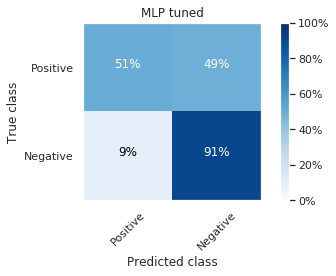

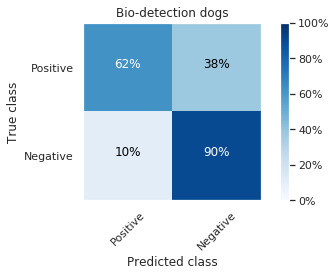

In [102]:
''' As per end test on MLP 1000/16/16/16/1
../logs/2019-05-12T16:36/private_correct_plus/devnet_summary.csv
[[39 38]
 [ 7 70]]
Class balance in test set: 77 to 77 i.e. 0.5
'''
cm = np.array(  [[0.50649351, 0.49350649],
                 [0.09090909, 0.90909091]])
acc = (cm[0][0]+cm[1][1])/(cm.sum())
plot_confusion_matrix(cm, title='MLP tuned', name='cm_MLPtuned_endTest')


dog_cm = np.array([[48, 29],
                    [8, 69]])
dog_acc = (dog_cm[0][0]+dog_cm[1][1])/(dog_cm.sum())
ND = dog_cm.sum()
dog_cm = dog_cm.astype('float') / dog_cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(dog_cm, title='Bio-detection dogs', name='cm_dog_endTest')

print('acc', acc, 'dog_acc', dog_acc, 'ND', ND)

acc 0.70779221


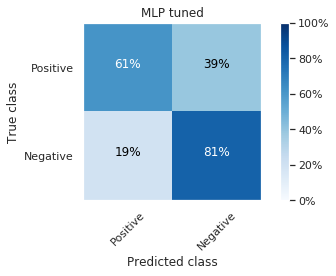

In [103]:
''' With probability threshold 0.3
[[47 30]
 [15 62]]
Calculated accuracy: 0.7077922077922078
'''  
cm = np.array([[0.61038961, 0.38961039],
               [0.19480519, 0.80519481]])
plot_confusion_matrix(cm, title='MLP tuned', name='cm_MLPtuned_endTest_threshold_0.3')
print('acc', (cm[0][0]+cm[1][1])/(cm.sum()))

# Dataset size vs accuracy
MLP 16/16/16

[ 17.  20.  27.  33.  40.  47.  50.  53.  60.  67.  68.  83. 100. 117.
 133. 150. 167. 183. 189.]
[ 8. 10. 13. 17. 20. 23. 25. 27. 30. 33. 34. 42. 50. 58. 67. 75. 83. 92.
 95.]


Text(0, 0.5, 'Mean validation accuracy')

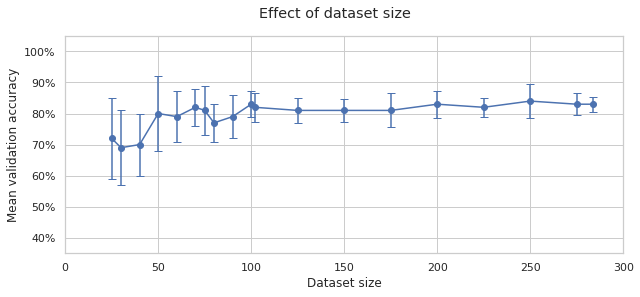

In [106]:
x = np.array([25,30,40,50,60,70,75,80,90,100,102,125,150,175,200,225,250,275,284])
mean_acc = [0.72,0.69,0.7,0.8,0.79,0.82,0.81,0.77,0.79,0.83,0.82,0.81,0.81,0.81,0.83,0.82,0.84,0.83,0.83]
acc_std = [0.13,0.12,0.1,0.12,0.082,0.059,0.08,0.062,0.07,0.042,0.046,0.04,0.036,0.055,0.044,0.03,0.055,0.035,0.024]


k = 3
x_train = np.round((x/k*(k-1)))
x_test = x-x_train

print(x_train)
print(x_test)

yerr = [acc_std, acc_std]
fig, ax = plt.subplots(figsize=(10, 4))
ax.errorbar(x, mean_acc, yerr,fmt='-o', capsize=4)

ax.set_ylim(bottom=0.35, top=1.05)
ax.set_xlim(left=0, right=300)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, 0))
plt.suptitle('Effect of dataset size')
ax.set_xlabel('Dataset size')
ax.set_ylabel('Mean validation accuracy')

Train on 189.0 acc 0.7 std 0.012
Train on 68.0 acc 0.7 std 0.015


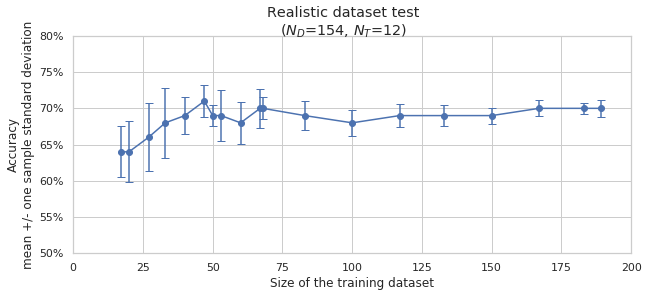

In [110]:
end_test_acc = [0.64,0.64,0.66,0.68,0.69,0.71,0.69,0.69,0.68,0.7,0.7,0.69,0.68,0.69,0.69,0.69,0.7,0.7,0.7]
end_test_std = [0.035,0.042,0.047,0.048,0.025,0.022,0.015,0.035,0.029,0.027,0.015,0.02,0.018,0.016,0.014,0.011,0.011,0.008,0.012]

yerr = [end_test_std, end_test_std]
fig, ax = plt.subplots(figsize=(10, 4))
ax.errorbar(x_train, end_test_acc, yerr,fmt='-o', capsize=4)

ax.set_ylim(bottom=0.5, top=0.8)
ax.set_xlim(left=0, right=200)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, 0))
num_text = '($N_D$='+str(154)+', $N_T$='+str(12)+')'
plt.suptitle('Realistic dataset test\n'+num_text)
ax.set_xlabel('Size of the training dataset')
ax.set_ylabel('Accuracy\nmean +/- one sample standard deviation')

print('Train on', x_train[-1], 'acc', end_test_acc[-1], 'std', end_test_std[-1])
print('Train on', x_train[10], 'acc', end_test_acc[10], 'std', end_test_std[10])